# Training Neural Nets, Part 2

In this notebook:

1. Improved Optimizers
2. Regularization in Layers
3. Dropout Layers
4. Tuning Hyperparameters

- Adopted from Hands-On Machine Learning by Geron

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Improved Optimizers

- Momentum
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam, AdaMax, Nadam, AdamW

Generally pretty simple to specify these, behold!

#### Momentum:

In [6]:
#Momentum is a hyperparameter
optimizer = tf.keras.optimizers.SGD(learning_rate=.001, momentum=0.9)

#### Nesterov accelerated gradient

- Nesterov trick is to look ahead, use gradient there
- Set `nesterov=True` for SGD optimizer:

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=.001, momentum=0.9, nesterov=True)

#### AdaGRad

In [10]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=.001)

#### RMSProp

In [12]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=.001, rho=.9)

#### Adam

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=.9, beta_2=.999)

#### AdaMax

In [16]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam

In [17]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### AdamW

In [18]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

- Can implement using a `LearningRateScheduler` callback
- An example of exponential decay::

In [21]:
#lr is optional current learning rate:
def exponential_decay(epoch, lr):
    #Hardcode s=10, eta0 = .01
    eta0 = .01
    s = 10
    
    return eta0 * 0.1 ** (epoch / s)

In [22]:
### Or example of piecewise constant:
#####
def piecewise_constant(epoch, lr):
    if epoch < 10:
        return 0.01
    elif epoch < 100:
        return 0.001
    else:
        return 0.0001

In [ ]:
## Would put in training like so:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

## Adding Regularization

- Can easily add L1 or L2 regularization

- Can add regularization to kernel, i.e. connection weights: Most typical

- Can also add regularization to bias and activity = output

- Use either `regularizers.L1L2`, `regularizers.L2`, or `regularizers.L2`:

- See: https://keras.io/api/layers/regularizers/

In [ ]:
layer = tf.keras.layers.Dense(
    units=64,
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
    bias_regularizer=tf.keras.regularizers.L1(1e-5),
    activity_regularizer=tf.keras.regularizers.L2(1e-5)
)

#### `partial` for wrapping:

- Can use to simplify layer construction:

In [ ]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.L2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")

## Max-Norm Regularization

- Can specifiy a maximum norm for the weights of a layer
- Rescale weights if the norm exceeds the maximum after each training step
- In Keras:

In [ ]:
layer = tf.keras.layers.Dense(64, kernel_constraint=tf.keras.constraints.max_norm(max_value=2))

## Dropout Regularization

- Randomly set some inputs to next layer to 0
- Dropout rate 10-50% typical
- Can use higher dropout rate for larger layers, smaller for smaller layers
- Can also try dropout only after last hidden layer
- Easy with `tf.keras.Dropout(rate)`

In [ ]:
#Example:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(10, activation="softmax")
])

## Monte Carlo Dropout

- Run model with dropout layers active to get multiple predictions
- Take average to get an ensemble prediction
- Can be more reliable, less sure of single answer
- Very simple to implement:

In [ ]:
#training=True says to behave as though training, e.g., leave Dropout layers active

y_probas = np.stack([model(X_test, training=True)
                     for i in range(100)])

#Average over the predictions:
y_proba = y_probas.mean(axis=0)

## Tuning HyperParameters

Let's use Keras Tuner library (May need to install)

We'll tune:

1. Number of hidden layers
2. Neurons per layer
3. Learning rate
4. Optimizer

- Need a function that builds, compiles, and returns a Keras model

- Takes `kt.HyperParameters` object as argument

In [7]:
#Load as usual:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


## Hold out some of the training data for validation:
######

## All but last 5,000 will be train data; last 5,000 will be validation
X_train, y_train = train_images[:-5000], train_labels[:-5000]

X_valid, y_valid = train_images[-5000:], train_labels[-5000:]

#Rename the test data for consistency:
X_test, y_test = test_images, test_labels


## And rescale everything to be between 0 and 1:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

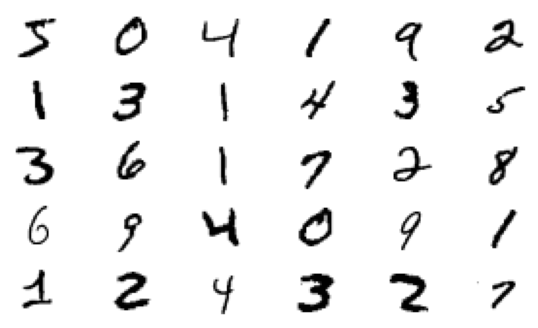

In [8]:
#Quickly plot:
fig1, ax1 = plt.subplots(5, 6, figsize=(7,4))
ax1 = ax1.flatten()

for i in range(30):
    ax1[i].imshow(X_train[i], cmap='gray_r')
    ax1[i].set_axis_off()
    

In [9]:
import keras_tuner as kt

#hp gives us our Hyperparameters:
def build_model(hp):
    
    #Number of hidden layers:
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    
    
    #Neurons per layer:
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, default=32)
    
    #Learning Rate?
    #We'll vary on a logarithmic scale
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    
    #Choose between three optimizers:
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", "nadam"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
        
    #Build the model using Sequential API:
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
    
    
    #Add layers:
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
        
        
    #Output:
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    #And compile
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    return model

Using TensorFlow backend


In [36]:
#Create the RandomSearch object:
#####

random_search_tuner = kt.RandomSearch(build_model,
                                      objective="val_accuracy",
                                      max_trials=10, overwrite=True,
                                      directory="my_tuner_stuff", project_name="my_rnd_search", seed=42)

In [37]:
##Now let's search:
########

#Just use a little bit of the training data for speed:
#######

random_search_tuner.search(X_train[:5000], y_train[:5000],
                           epochs=5,
                           validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.9157999753952026

Best val_accuracy So Far: 0.9485999941825867
Total elapsed time: 00h 00m 33s


In [38]:
## Get the best models:
best3 = random_search_tuner.get_best_models(num_models=3)

In [39]:
#We have:
best3

In [40]:
#Extract number 1
best_model = best3[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 124)               97340     
                                                                 
 dense_1 (Dense)             (None, 124)               15500     
                                                                 
 dense_2 (Dense)             (None, 124)               15500     
                                                                 
 dense_3 (Dense)             (None, 124)               15500     
                                                                 
 dense_4 (Dense)             (None, 124)               15500     
                                                                 
 dense_5 (Dense)             (None, 124)               1

In [41]:
## And associated hyperparameters?
######

best3_hyper = random_search_tuner.get_best_hyperparameters(num_trials=3)
best3_hyper

In [42]:
best3_hyper[0].values

{'n_hidden': 7,
 'n_neurons': 124,
 'learning_rate': 0.0005509513888645584,
 'optimizer': 'nadam'}

In [43]:
## We can also consult the Oracle:

best_trials = random_search_tuner.oracle.get_best_trials(num_trials=3)
best_trials

In [44]:
best_trials[0].summary()

Trial 08 summary
Hyperparameters:
n_hidden: 7
n_neurons: 124
learning_rate: 0.0005509513888645584
optimizer: nadam
Score: 0.9485999941825867


In [45]:
### Now that we have the best of our candidate models, can also train a little further on full train set
##########

best_model.fit(X_train, y_train,
               epochs=5,
               validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 5s 2ms/step - loss: 0.1771 - accuracy: 0.9477 - val_loss: 0.1304 - val_accuracy: 0.9620
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1102 - accuracy: 0.9677 - val_loss: 0.0856 - val_accuracy: 0.9756
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0859 - accuracy: 0.9746 - val_loss: 0.0885 - val_accuracy: 0.9740
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0697 - accuracy: 0.9791 - val_loss: 0.1002 - val_accuracy: 0.9716
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0572 - accuracy: 0.9823 - val_loss: 0.1004 - val_accuracy: 0.9726


### Other Methods?

- Several other Keras tuners
- Can also use `KerasRegressor` and `KerasClassifier` wrappers from SciKeras and use `GridSearchCV` or `RandomizedSearchCV`
- Evolutionary algorithms active area of research
- Can always write your own

In [46]:
## Bayesian Tuner:
#Has own hyperparameters: alpha and beta
#alpha represents level of noise you expect in performance measures across trials
#beta indicates how much of parameter space you should explore
#Defaults below:
##########

bayesian_tuner = kt.BayesianOptimization(
                        build_model, objective="val_accuracy", seed=42,
                        max_trials=10,
                        alpha=1e-4, beta=2.6,
                        overwrite=True, directory="my_tuner_stuff", project_name="bayesian_search")

In [47]:
#And do the search:
####

bayesian_tuner.search(X_train[:5000], y_train[:5000], epochs=5,
                          validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.9269999861717224

Best val_accuracy So Far: 0.9476000070571899
Total elapsed time: 00h 00m 53s


In [54]:
best_trials = bayesian_tuner.oracle.get_best_trials(num_trials=3)
best_trials[0].summary()

Trial 08 summary
Hyperparameters:
n_hidden: 7
n_neurons: 124
learning_rate: 0.0005509513888645584
optimizer: nadam
Score: 0.9476000070571899
